In [0]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [0]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.619893,0.928221,00:00
1,0.846406,0.670930,00:00
2,0.655806,0.671284,00:00


###CollabLearner Source Code

In [0]:
"Module support for Collaborative Filtering"
# from .tabular import * change this line to
from fastai.tabular import *
from . import tabular

__all__ = [*tabular.__all__, 'EmbeddingDotBias', 'EmbeddingNN', 'collab_learner', 'CollabDataBunch', 'CollabLine',
           'CollabList', 'CollabLearner']

class CollabProcessor(TabularProcessor):
    "Subclass `TabularProcessor for `process_one`."
    def process_one(self, item):
        res = super().process_one(item)
        return CollabLine(res.cats,res.conts,res.classes,res.names)

class CollabLine(TabularLine):
    "Base item for collaborative filtering, subclasses `TabularLine`."
    def __init__(self, cats, conts, classes, names):
        super().__init__(cats, conts, classes, names)
        self.data = [self.data[0][0],self.data[0][1]]

class CollabList(TabularList):
    "Base `ItemList` for collaborative filtering, subclasses `TabularList`."
    _item_cls,_label_cls,_processor = CollabLine,FloatList,CollabProcessor

    def reconstruct(self, t:Tensor): return CollabLine(tensor(t), tensor([]), self.classes, self.col_names)

class EmbeddingNN(TabularModel):
    "Subclass `TabularModel` to create a NN suitable for collaborative filtering."
    def __init__(self, emb_szs:ListSizes, layers:Collection[int]=None, ps:Collection[float]=None,
                 emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__(emb_szs=emb_szs, n_cont=0, out_sz=1, layers=layers, ps=ps, emb_drop=emb_drop, y_range=y_range,
                         use_bn=use_bn, bn_final=bn_final)

    def forward(self, users:LongTensor, items:LongTensor) -> Tensor:
        return super().forward(torch.stack([users,items], dim=1), None)

class EmbeddingDotBias(Module):
    "Base dot model for collaborative filtering."
    def __init__(self, n_factors:int, n_users:int, n_items:int, y_range:Tuple[float,float]=None):
        self.y_range = y_range
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [embedding(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users:LongTensor, items:LongTensor) -> Tensor:
        dot = self.u_weight(users)* self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_range is None: return res
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]

class CollabDataBunch(DataBunch):
    "Base `DataBunch` for collaborative filtering."
    @classmethod
    def from_df(cls, ratings:DataFrame, valid_pct:float=0.2, user_name:Optional[str]=None, item_name:Optional[str]=None,
                rating_name:Optional[str]=None, test:DataFrame=None, seed:int=None, path:PathOrStr='.', bs:int=64, 
                val_bs:int=None, num_workers:int=defaults.cpus, dl_tfms:Optional[Collection[Callable]]=None, 
                device:torch.device=None, collate_fn:Callable=data_collate, no_check:bool=False) -> 'CollabDataBunch':
        "Create a `DataBunch` suitable for collaborative filtering from `ratings`."
        user_name   = ifnone(user_name,  ratings.columns[0])
        item_name   = ifnone(item_name,  ratings.columns[1])
        rating_name = ifnone(rating_name,ratings.columns[2])
        cat_names = [user_name,item_name]
        src = (CollabList.from_df(ratings, cat_names=cat_names, procs=Categorify)
               .split_by_rand_pct(valid_pct=valid_pct, seed=seed).label_from_df(cols=rating_name))
        if test is not None: src.add_test(CollabList.from_df(test, cat_names=cat_names))
        return src.databunch(path=path, bs=bs, val_bs=val_bs, num_workers=num_workers, device=device, 
                             collate_fn=collate_fn, no_check=no_check)

class CollabLearner(Learner):
    "`Learner` suitable for collaborative filtering."
    def get_idx(self, arr:Collection, is_item:bool=True):
        "Fetch item or user (based on `is_item`) for all in `arr`. (Set model to `cpu` and no grad.)"
        m = self.model.eval().cpu()
        requires_grad(m,False)
        u_class,i_class = self.data.train_ds.x.classes.values()
        classes = i_class if is_item else u_class
        c2i = {v:k for k,v in enumerate(classes)}
        try: return tensor([c2i[o] for o in arr])
        except Exception as e: 
            print(f"""You're trying to access {'an item' if is_item else 'a user'} that isn't in the training data.
                  If it was in your original data, it may have been split such that it's only in the validation set now.""")

    def bias(self, arr:Collection, is_item:bool=True):
        "Bias for item or user (based on `is_item`) for all in `arr`. (Set model to `cpu` and no grad.)"
        idx = self.get_idx(arr, is_item)
        m = self.model
        layer = m.i_bias if is_item else m.u_bias
        return layer(idx).squeeze()

    def weight(self, arr:Collection, is_item:bool=True):
        "Weight for item or user (based on `is_item`) for all in `arr`. (Set model to `cpu` and no grad.)"
        idx = self.get_idx(arr, is_item)
        m = self.model
        layer = m.i_weight if is_item else m.u_weight
        return layer(idx)

def collab_learner(data, n_factors:int=None, use_nn:bool=False, emb_szs:Dict[str,int]=None, layers:Collection[int]=None, 
                   ps:Collection[float]=None, emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, 
                   bn_final:bool=False, **learn_kwargs)->Learner:
    "Create a Learner for collaborative filtering on `data`."
    emb_szs = data.get_emb_szs(ifnone(emb_szs, {}))
    u,m = data.train_ds.x.classes.values()
    if use_nn: model = EmbeddingNN(emb_szs=emb_szs, layers=layers, ps=ps, emb_drop=emb_drop, y_range=y_range, 
                                   use_bn=use_bn, bn_final=bn_final, **learn_kwargs)
    else:      model = EmbeddingDotBias(n_factors, len(u), len(m), y_range=y_range)
    return CollabLearner(data, model, **learn_kwargs)

In [57]:
help(ifnone)

Help on function ifnone in module fastai.core:

ifnone(a:Any, b:Any) -> Any
    `a` if `a` is not None, otherwise `b`.



## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [0]:
#If using this then comment the next cell
# from google.colab import files
# files.upload()

Saving ml-100k.zip to ml-100k (1).zip


In [9]:
#  http://files.grouplens.org/datasets/movielens/ml-100k.zip
 import requests


url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
r = requests.get(url, allow_redirects=True)

open('ml-100k.zip', 'wb').write(r.content)

4924029

In [0]:
from zipfile import ZipFile
zip = ZipFile("ml-100k.zip")
zip.extractall()

In [11]:
!ls

ml-100k  ml-100k.zip  sample_data


In [0]:
!mv  ml-100k/ /root/.fastai/data/

In [14]:
path=Config.data_path()/'ml-100k'
# path = /content/"ml-100k"
path.ls()

[PosixPath('/root/.fastai/data/ml-100k/ub.base'),
 PosixPath('/root/.fastai/data/ml-100k/u2.test'),
 PosixPath('/root/.fastai/data/ml-100k/README'),
 PosixPath('/root/.fastai/data/ml-100k/u2.base'),
 PosixPath('/root/.fastai/data/ml-100k/u5.base'),
 PosixPath('/root/.fastai/data/ml-100k/ua.test'),
 PosixPath('/root/.fastai/data/ml-100k/u1.test'),
 PosixPath('/root/.fastai/data/ml-100k/u.genre'),
 PosixPath('/root/.fastai/data/ml-100k/u1.base'),
 PosixPath('/root/.fastai/data/ml-100k/u3.test'),
 PosixPath('/root/.fastai/data/ml-100k/u.occupation'),
 PosixPath('/root/.fastai/data/ml-100k/u.user'),
 PosixPath('/root/.fastai/data/ml-100k/u3.base'),
 PosixPath('/root/.fastai/data/ml-100k/u4.test'),
 PosixPath('/root/.fastai/data/ml-100k/allbut.pl'),
 PosixPath('/root/.fastai/data/ml-100k/u4.base'),
 PosixPath('/root/.fastai/data/ml-100k/u.item'),
 PosixPath('/root/.fastai/data/ml-100k/u.info'),
 PosixPath('/root/.fastai/data/ml-100k/u.data'),
 PosixPath('/root/.fastai/data/ml-100k/u5.test')

In [14]:
# !ls /root/.fastai/data/

ml-100k  movie_lens_sample  movie_lens_sample.tgz


In [16]:
# path.ls()

[PosixPath('/root/.fastai/data/movie_lens_sample/ratings.csv')]

In [15]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [54]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [55]:
len(ratings)

100000

In [56]:
item, title

('movieId', 'title')

In [57]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [59]:
data.show_batch()

userId,title,target
43,Sleepers (1996),3.0
601,William Shakespeare's Romeo and Juliet (1996),1.0
711,Michael Collins (1996),4.0
250,"Saint, The (1997)",2.0
439,"Devil's Advocate, The (1997)",3.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


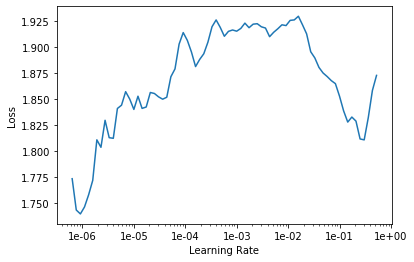

In [62]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [63]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.962958,0.952999,00:12
1,0.882616,0.879708,00:11
2,0.760480,0.837433,00:11
3,0.660213,0.812120,00:11
4,0.575565,0.811823,00:11


In [0]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [0]:
learn.load('dotprod');

In [66]:
len(rating_movie["userId"].unique()), len(rating_movie["title"].unique())

(943, 1664)

In [67]:
#for each userId and title we have embedding vector of size 40 ie n_factors in collab_learner
learn.model 

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [68]:
g = rating_movie.groupby(title)['rating'].count() #getting top_movies based on count of user rating
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [69]:
movie_bias = learn.bias(top_movies, is_item=True) #getting bias of top 1000 movies
movie_bias.shape, len(top_movies)

(torch.Size([1000]), 1000)

In [0]:
##defined my on zip since it was conflicting with zip of zipfile
def myZip(*iterables):
    # zip('ABCD', 'xy') --> Ax By
    sentinel = object()
    iterators = [iter(it) for it in iterables]
    while iterators:
        result = []
        for it in iterators:
            elem = next(it, sentinel)
            if elem is sentinel:
                return
            result.append(elem)
        yield tuple(result)

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in myZip(top_movies,movie_bias)]

In [81]:
movie_ratings[0], type(movie)

(tensor(0.5118), 'Star Wars (1977)', 4.3584905660377355)

In [0]:
item0 = lambda o:o[0]

In [88]:
sorted(movie_ratings, key=item0)[:15] #key decide based on which element it should be sorted

[(tensor(-0.3709),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3541),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2920), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2780), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2712), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2667), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2574), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2428), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2417), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2398), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2374), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2171), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2164), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2160), 'Lawnmower Man, The (1992)', 2.4461538461538463),
 (tensor(-0.2154), 'Thinner (1

In [0]:
# sorted(movie_ratings)[:15]

In [90]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5901), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5758), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5687), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5545), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5448), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5194), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5118), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5114), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5024), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4971), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4872), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4872), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4791), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4744), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4695), 'Boot, Das (1981)', 4.203980099502488)]

### Movie weights

In [91]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [99]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in myZip(fac0, top_movies)]

In [102]:
movie_comp[:5]

[(tensor(-0.7257), 'Star Wars (1977)'),
 (tensor(-0.1000), 'Contact (1997)'),
 (tensor(-0.9043), 'Fargo (1996)'),
 (tensor(-0.1688), 'Return of the Jedi (1983)'),
 (tensor(0.6586), 'Liar Liar (1997)')]

In [104]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10] #itemgetter help us to decide on what value sorted will sort if multiple value are present in element to sort

[(tensor(1.2369), 'Jungle2Jungle (1997)'),
 (tensor(1.2329), 'Home Alone 3 (1997)'),
 (tensor(1.2029), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.1594), "McHale's Navy (1997)"),
 (tensor(1.1550), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.1358), 'Leave It to Beaver (1997)'),
 (tensor(1.1089), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.0913), 'Congo (1995)'),
 (tensor(1.0506), 'Flipper (1996)'),
 (tensor(1.0435), 'Bio-Dome (1996)')]

In [105]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0489), 'Wrong Trousers, The (1993)'),
 (tensor(-1.0385), 'Chinatown (1974)'),
 (tensor(-1.0288), 'Close Shave, A (1995)'),
 (tensor(-0.9938), 'Lawrence of Arabia (1962)'),
 (tensor(-0.9929), 'Casablanca (1942)'),
 (tensor(-0.9708), 'Secrets & Lies (1996)'),
 (tensor(-0.9572), 'North by Northwest (1959)'),
 (tensor(-0.9508), 'Apocalypse Now (1979)'),
 (tensor(-0.9439), 'Citizen Kane (1941)'),
 (tensor(-0.9428), 'Some Folks Call It a Sling Blade (1993)')]

In [0]:
movie_comp = [(f, i) for f,i in myZip(fac1, top_movies)]

In [107]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2084), 'Braveheart (1995)'),
 (tensor(1.0510), 'Titanic (1997)'),
 (tensor(1.0209), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9449), "It's a Wonderful Life (1946)"),
 (tensor(0.8824), 'American President, The (1995)'),
 (tensor(0.8759), 'Star Wars (1977)'),
 (tensor(0.8756), 'Forrest Gump (1994)'),
 (tensor(0.8577), 'Sleepless in Seattle (1993)'),
 (tensor(0.8369), 'Independence Day (ID4) (1996)'),
 (tensor(0.8347), 'Affair to Remember, An (1957)')]

In [108]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9892), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8092), 'Dead Man (1995)'),
 (tensor(-0.7980), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7961), 'Keys to Tulsa (1997)'),
 (tensor(-0.7877), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7800), 'Trainspotting (1996)'),
 (tensor(-0.7498), 'Brazil (1985)'),
 (tensor(-0.7495), 'Cable Guy, The (1996)'),
 (tensor(-0.7380), 'Sweet Hereafter, The (1997)'),
 (tensor(-0.7353), 'Crumb (1994)')]

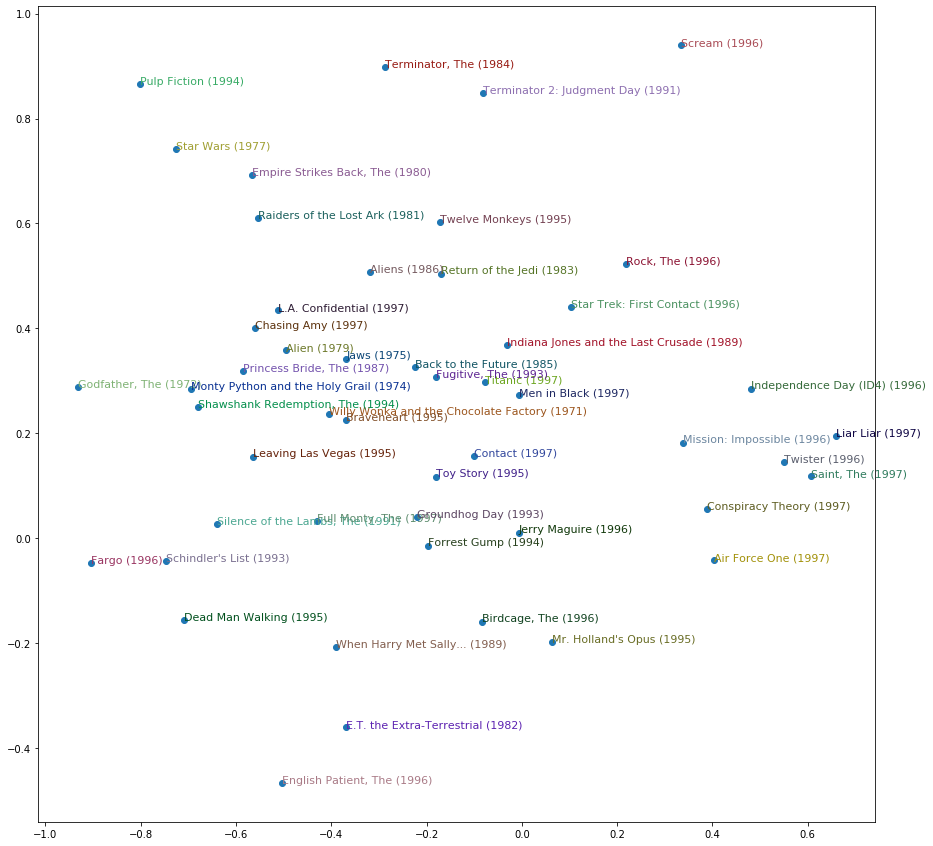

In [117]:
# idxs = np.random.choice(len(top_movies), 50, replace=False) #uncomment this line and comment second line to randomly select movies to plot 
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in myZip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()